# Inference: No-U-Turn (NUTS) MCMC

This example shows you how to perform Bayesian inference on a time-series problem, using [No-U-Turn Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/nuts_mcmc.html) (NUTS). 
NUTS is a variant on the original [Hamiltonian MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html), but features a number of adaptive features that aims to reduce the number of hyper-paramters to zero. 
Dual averaging is used to adapt the step size $\epsilon$ and mass matrix $M$. 
More importantly, the NUTS algorithm makes an optimal choice for the number of steps per iteration ($L$), which depends on the local position of the particle in parameter space. 
If the particle is in a relatively flat (low) region, then a higher $L$ is optimal to move away from this uninteresting area towards regions of higher density. 
If it is in a region with more curvature, choosing a high value for $L$ can be inefficient because the particle may start to re-explore parts of space already visited; it   may execute "U-Turns"                     

NUTS is the default sampler for packages such as [Stan](https://mc-stan.org/), [PyMC3](https://docs.pymc.io/) and [Pyro](http://pyro.ai/), so including this sampler in Pints is useful for comparison with these libraries. 
However, it must be noted that the exact implementation will differ slightly between each library, so care must be taken when interpreting results.
Our goal with the Pints implementation was to reproduce the Stan version of NUTS as best we could.

First, we set up a problem using the logistic growth toy problem.

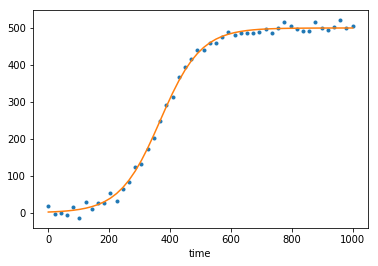

In [2]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.')
plt.plot(times, org_values)
plt.xlabel('time')
plt.show()

Now we set up and run a sampling routine using No-U-Turn MCMC. In the initialisation of the No-U-Turn algorithm the sampler tries to find a reasonable value for `epsilon`, the leapfrog step size, which results in many overflows seen from evaluating the logistic model.

In [4]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(1500)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     39     0.314    2       0.389    1       0.5      1        0:00.0
1     42     0.25     1       0.25     1       0.25     1        0:00.0
2     45     0.25     1       0.25     1                         0:00.0
3     48     0.5      1       0.5      1                         0:00.0
100   110070  0.787736 375     0.825    50      0.783    169      0:32.6
200   209925  0.768    330     0.906    58      0.854    46       0:58.9
300   246244  0.778    128     0.906    61      0.908361 59       1:08.4
400   258056  0.787    59                       0.925089 55       1:11.4
500   269572  0.784    57                       0.883    60       1:14.4
600   281948  0.861    62                       0.922    68       1:17.7
700   289793  0.886    63                       0.849    48       1:19.8
800   296357  0.847    65                       

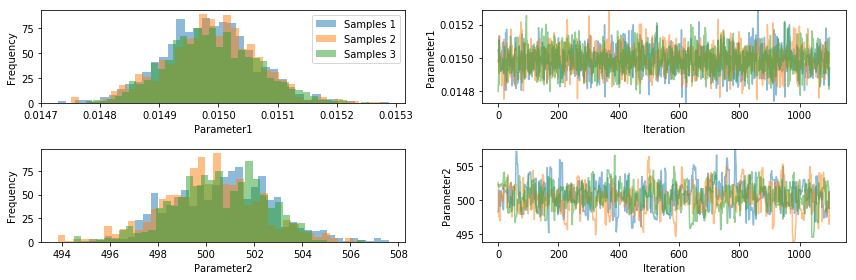

R-hat:
[1.00038656 1.01060596]


In [5]:
# Discard warm-up
nuts_chains = nuts_chains[:, 400:]

pints.plot.trace(nuts_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat(nuts_chains))

We can do the same using Hamiltonian MCMC.
Note that this implementation of HMC does not use dual-averaging for the step size, nor does it use an adaptive mass matrix like the NUTS implementation, so we expect HMC to be much less efficient than the tuned NUTS sampler.

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0          0:00.0
2     123    0.5       0.5       0          0:00.0
3     183    0.6       0.6       0          0:00.1
100   6003   0.98      0.98      0.931      0:01.2
200   12003  0.990099  0.990099  0.965      0:02.4
300   18003  0.993     0.993     0.977      0:03.6
400   24003  0.993     0.995     0.98       0:05.0
500   30003  0.994     0.996     0.984      0:06.2
600   36003  0.995     0.995     0.986711   0:07.4
700   42003  0.996     0.994302  0.987      0:08.4
800   48003  0.995     0.994     0.989      0:09.5
900   54003  0.994     0.993     0.99       0:10.6
1000  60003  0.99501   0.994012  0.991018   0:11.7
1100  66003  0.995     0.993     0.991833   0:12.9
1200  72003  0.996     0.993     0.993      0:14.1
1300  78003  0.995     0.993     0.993     

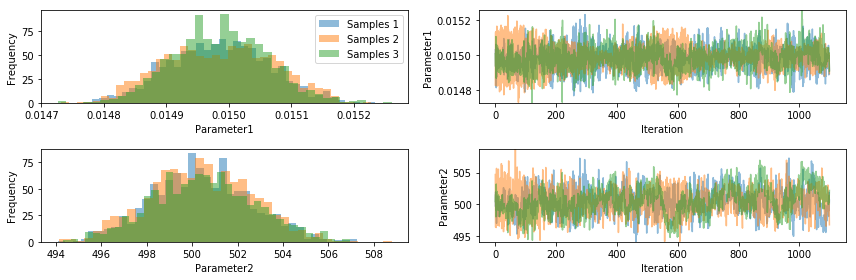

R-hat:
[1.00046954 1.00508381]


In [8]:
# Create mcmc routine
h_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.HamiltonianMCMC)
h_mcmc.set_max_iterations(1500)

# Set up modest logging
h_mcmc.set_log_to_screen(True)
h_mcmc.set_log_interval(100)

# Run!
print('Running...')
h_chains = h_mcmc.run()
print('Done!')

# Discard warm up
h_chains = h_chains[:, 400:]

pints.plot.trace(h_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat(h_chains))

Both samplers converge according to the R-hat measure, and both sets of chains are clearly mixing well and sampling the posterior correctly.
However, the adaptive stepping in the NUTS sampler results in an **order of magnitude** less function evaluations.

We can check the Estimated Sample Size (ESS) for both methods as well, which shows that NUTS also gives a slightly more consistent ESS across the two parameters.

In [9]:
# Check convergence using rhat criterion
print('NUTS Minimum ESS:')
print(np.min([pints.effective_sample_size(nuts_chains[i,:,:]) for i in range(nuts_chains.shape[0])],axis=0))
print('\nHamiltonian Minimum ESS:')
print(np.min([pints.effective_sample_size(h_chains[i,:,:]) for i in range(h_chains.shape[0])],axis=0))


NUTS Minimum ESS:
[275.00125264 110.11342778]

Hamiltonian Minimum ESS:
[366.66666667  30.9550772 ]
